In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline,
    AutoConfig
)

import torch
from torchinfo import summary

2023-03-24 07:12:59.823592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 07:13:00.030931: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-24 07:13:00.809132: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.3.222/linux/mpi/intel64/lib:/opt/intel/compilers_and_libraries_2018.3.222/linux/mpi/mic/lib::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2023-03-24 07:13:00.8

In [2]:
df_ = pd.read_csv('../data/AirlineTweets.csv')

In [3]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df = df_[['airline_sentiment','text']].copy()

In [5]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<AxesSubplot: >

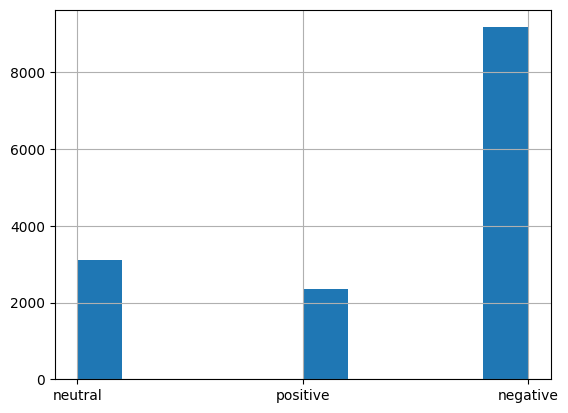

In [6]:
df['airline_sentiment'].hist()

In [7]:
target_map = {'positive':1, 'negative':0, 'neutral':2}
df['target'] = df['airline_sentiment'].map(target_map)

In [8]:
df2 = df[['text','target']]
df2.columns = ['sentence','label']
df2.to_csv('../data/data.csv', index = None)

In [9]:
raw_dataset = load_dataset('csv', data_files = '../data/data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/azureuser/.cache/huggingface/datasets/csv/default-d953ba33643e1446/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


/anaconda/envs/transformer-gpu-env/lib/python3.8/site-packages/datasets/download/streaming_download_manager.py:776: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [11]:
split = raw_dataset['train'].train_test_split(test_size = 0.3, seed = 42)

In [12]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [13]:
checkpoint = 'distilbert-base-cased'

In [14]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [15]:
def tokenize_fn(batch):
    return tokenizer(batch['sentence'], truncation=True)

In [16]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [17]:
config = AutoConfig.from_pretrained(checkpoint)

In [18]:
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 28996
}

In [19]:
config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [20]:
config.label2id

{'LABEL_0': 0, 'LABEL_1': 1}

In [21]:
config.id2label = {v:k for k, v in target_map.items()}
config.label2id = target_map

In [22]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, config=config
)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bia

In [23]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [24]:
training_args = TrainingArguments(
    output_dir = 'training_dir',
    evaluation_strategy='epoch',
    save_strategy = 'epoch',
    num_train_epochs = 3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
)

In [25]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions==labels)
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy':acc, 'f1':f1}

In [26]:
trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["test"],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

In [27]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/anaconda/envs/transformer-gpu-env/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10248
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1923
  Number of trainable parameters = 65783811


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.546300,0.431890,0.826503,0.773953
2,0.353200,0.504058,0.828552,0.778387
3,0.238600,0.648342,0.836521,0.782442


Attempted to log scalar metric loss:
0.5463
Attempted to log scalar metric learning_rate:
3.699947997919917e-05
Attempted to log scalar metric epoch:
0.78


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4392
  Batch size = 64


Attempted to log scalar metric eval_loss:
0.4318901300430298
Attempted to log scalar metric eval_accuracy:
0.8265027322404371
Attempted to log scalar metric eval_f1:
0.7739530786378063
Attempted to log scalar metric eval_runtime:
13.5437
Attempted to log scalar metric eval_samples_per_second:
324.283
Attempted to log scalar metric eval_steps_per_second:
5.095
Attempted to log scalar metric epoch:
1.0


Saving model checkpoint to training_dir/checkpoint-641
Configuration saved in training_dir/checkpoint-641/config.json
Model weights saved in training_dir/checkpoint-641/pytorch_model.bin
tokenizer config file saved in training_dir/checkpoint-641/tokenizer_config.json
Special tokens file saved in training_dir/checkpoint-641/special_tokens_map.json


Attempted to log scalar metric loss:
0.3532
Attempted to log scalar metric learning_rate:
2.399895995839834e-05
Attempted to log scalar metric epoch:
1.56


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4392
  Batch size = 64


Attempted to log scalar metric eval_loss:
0.5040578842163086
Attempted to log scalar metric eval_accuracy:
0.828551912568306
Attempted to log scalar metric eval_f1:
0.7783873846553759
Attempted to log scalar metric eval_runtime:
13.7271
Attempted to log scalar metric eval_samples_per_second:
319.952
Attempted to log scalar metric eval_steps_per_second:
5.027
Attempted to log scalar metric epoch:
2.0


Saving model checkpoint to training_dir/checkpoint-1282
Configuration saved in training_dir/checkpoint-1282/config.json
Model weights saved in training_dir/checkpoint-1282/pytorch_model.bin
tokenizer config file saved in training_dir/checkpoint-1282/tokenizer_config.json
Special tokens file saved in training_dir/checkpoint-1282/special_tokens_map.json


Attempted to log scalar metric loss:
0.2386
Attempted to log scalar metric learning_rate:
1.0998439937597505e-05
Attempted to log scalar metric epoch:
2.34


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4392
  Batch size = 64


Attempted to log scalar metric eval_loss:
0.6483418345451355
Attempted to log scalar metric eval_accuracy:
0.8365209471766849
Attempted to log scalar metric eval_f1:
0.7824421268764908
Attempted to log scalar metric eval_runtime:
13.7719
Attempted to log scalar metric eval_samples_per_second:
318.911
Attempted to log scalar metric eval_steps_per_second:
5.01
Attempted to log scalar metric epoch:
3.0


Saving model checkpoint to training_dir/checkpoint-1923
Configuration saved in training_dir/checkpoint-1923/config.json
Model weights saved in training_dir/checkpoint-1923/pytorch_model.bin
tokenizer config file saved in training_dir/checkpoint-1923/tokenizer_config.json
Special tokens file saved in training_dir/checkpoint-1923/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




Attempted to log scalar metric train_runtime:
404.13
Attempted to log scalar metric train_samples_per_second:
76.075
Attempted to log scalar metric train_steps_per_second:
4.758
Attempted to log scalar metric total_flos:
388376501242176.0
Attempted to log scalar metric train_loss:
0.3305944005338339
Attempted to log scalar metric epoch:
3.0


TrainOutput(global_step=1923, training_loss=0.3305944005338339, metrics={'train_runtime': 404.13, 'train_samples_per_second': 76.075, 'train_steps_per_second': 4.758, 'total_flos': 388376501242176.0, 'train_loss': 0.3305944005338339, 'epoch': 3.0})

In [28]:
!ls training_dir

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
checkpoint-1282  checkpoint-1923  checkpoint-641  runs


In [29]:
saved_model = pipeline('text-classification',
                       model='training_dir/checkpoint-1282',
                       device=0)

loading configuration file training_dir/checkpoint-1282/config.json
Model config DistilBertConfig {
  "_name_or_path": "training_dir/checkpoint-1282",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "negative",
    "1": "positive",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "label2id": {
    "negative": 0,
    "neutral": 2,
    "positive": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "vocab_size": 28996
}

loading configuration file training_dir/checkpoint-1282/config.json
Model config DistilBertConfig {


In [30]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [31]:
test_pred = saved_model(split['test']['sentence'])

Disabling tokenizer parallelism, we're using DataLoader multithreading already


In [32]:
test_pred

[{'label': 'positive', 'score': 0.9551592469215393},
 {'label': 'positive', 'score': 0.9053266048431396},
 {'label': 'negative', 'score': 0.7063663601875305},
 {'label': 'positive', 'score': 0.8024816513061523},
 {'label': 'neutral', 'score': 0.9045398235321045},
 {'label': 'negative', 'score': 0.9950581789016724},
 {'label': 'neutral', 'score': 0.9104073643684387},
 {'label': 'neutral', 'score': 0.9775722622871399},
 {'label': 'positive', 'score': 0.6343450546264648},
 {'label': 'negative', 'score': 0.9964470267295837},
 {'label': 'negative', 'score': 0.9684076905250549},
 {'label': 'negative', 'score': 0.9898993372917175},
 {'label': 'positive', 'score': 0.9430466890335083},
 {'label': 'negative', 'score': 0.990909993648529},
 {'label': 'neutral', 'score': 0.989190936088562},
 {'label': 'neutral', 'score': 0.6101106405258179},
 {'label': 'negative', 'score': 0.6883207559585571},
 {'label': 'negative', 'score': 0.9961438179016113},
 {'label': 'negative', 'score': 0.8157957196235657},


In [33]:
def get_label(d):
    return int(d['label'].split('_')[1])

In [34]:
test_pred = [get_label(d) for d in test_pred]

IndexError: list index out of range

In [ ]:
print("Acc:", accuracy_score(split['test']['label'], test_pred))

In [ ]:
print("F1 Score:",f1_score(split['test']['label'], test_pred,average='macro'))

In [ ]:
def plot_confusion_matrix(cm):
    classes = ['negative', 'posotive', 'neutral']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

cm = confusion_matrix(split['test']['label'], test_pred, normalize = 'true')
plot_confusion_matrix(cm)    

In [ ]:
s = split['test']['sentence'][0]
print(s)
saved_model(s)